# IndiaSim Graph-Style ABM Model Prototype

Built for Julia 1.2.1. Redesigned for Julia 1.7.3 in July 2022. A simplistic model based on Agents.jl's example SIR model (https://juliadynamics.github.io/Agents.jl/stable/examples/sir/). Numerous key edits have been made that dramatically change the model for our purposes.


In essence, children are on a fully connected network and transmit infections to each other.

TO DO: (1) Correct transmission dynamics, (2) add vaccinations, and (3) estimate antibiotoic use

Chirag K. Kumar -- ckkumar@princeton.edu

In [15]:
import Pkg # for installing packages/package manager

In [16]:
# get packages that are necessary or install them if they don't exist in the current environment
Pkg.add(["Agents", "Random", "DataFrames", "Graphs", "Distributions", "DrWatson", "Plots"])

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
  0 dependencies successfully precompiled in 1 seconds (225 already precompiled, 14 skipped during auto due to previous errors)
  4 dependencies errored. To see a full report either run `import Pkg; Pkg.precompile()` or load the packages


In [17]:
using Plots

In [18]:
using Agents, Random, DataFrames, Graphs
using Distributions: Poisson, DiscreteNonParametric
using DrWatson: @dict

In [19]:
# may be good to upgrade this with the specific syntax
# @agent PoorSoul GraphAgent begin # then can drop the pos

mutable struct PoorSoul <: AbstractAgent
    id::Int
    pos::Int
    days_infected::Int  # number of days since is infected
    status::Symbol  # 1: S, 2: I, 3:R
    # let's add in SAGE-W
    # state::Symbol
    age_cat::Int
    # gender::Symbol
    # education::Int
    # wealth::Int
    # room for adding in whatever else later
end

In [33]:
# convenient to wrap the initialization of the model in a function that calls all the necessary subroutines, etc, etc.....

# parameters for the transmission of the infection
# the key idea is to have a modular design so that we can easily flip and flip out new pathogens
function model_initiation(;
    N_total,
    contact_matrix,
    β_und,
    β_det,
    infection_period = 3,
    reinfection_probability = 0.0,
    detection_time = 14,
    death_rate = 0.02,
    killed_agents,
    seed = 108,
)

    rng = MersenneTwister(seed)
    # normalize migration_rates
    contact_matrix_sum = sum(contact_matrix, dims = 2)
    for c in 1:80
        contact_matrix[c, :] ./= contact_matrix_sum[c]
    end

    properties = @dict(
        N_total,
        β_und,
        β_det,
        β_det,
        contact_matrix,
        infection_period,
        infection_period,
        reinfection_probability,
        detection_time,
        death_rate,
        killed_agents
    )

    # wonder if there's a clever way to do what we do below with the interaction_matrix by using a SimpleWeightedDiGraph
    # and baking in the weights
    space = GraphSpace(complete_digraph(N_total)) # everyone connected to everyone else
    model = ABM(PoorSoul, space; properties, rng)

    # Add initial individuals
    prevalence = 0.2
    for n in 1:N_total
        if rand(rng) <= prevalence
            ind = add_agent!(n, model, 0, :I, rand(1:80)) # ages and gender whatnot should be pulled from nfhs data
        else
            ind = add_agent!(n, model, 0, :S, rand(1:80))
        end
    end
    # add infected individuals
    return model
end

model_initiation (generic function with 1 method)

In [39]:
using LinearAlgebra: diagind

function create_params(;
    N_total,
    infection_period = 3,
    reinfection_probability = 0.00,
    detection_time = 14,
    death_rate = 0.02,
    seed = 108,
)

    Random.seed!(seed)
    β_und = rand(0.3:0.02:0.6) * 0.333
    β_det = β_und ./ 10

    Random.seed!(seed)
    contact_matrix = zeros(80, 80)
    for c in 1:80
        for c2 in 1:80
            contact_matrix[c, c2] = rand()
        end
    end
    maxM = maximum(contact_matrix)
    contact_matrix = (contact_matrix) ./ maxM
    contact_matrix[diagind(contact_matrix)] .= 1.0
    killed_agents = Vector{Float64}()

    params = @dict(
        N_total,
        β_und,
        β_det,
        contact_matrix,
        infection_period,
        reinfection_probability,
        detection_time,
        death_rate,
        killed_agents)

    return params
end

params = create_params(N_total = 10)
model = model_initiation(; params...)

AgentBasedModel with 10 agents of type PoorSoul
 space: GraphSpace with 10 positions and 90 edges
 scheduler: fastest
 properties: death_rate, killed_agents, infection_period, β_und, contact_matrix, detection_time, N_total, β_det, reinfection_probability

In [40]:
# annoyingly i haven't figured out a way to do this as part of the class
# basically, store the probabilities of interaction with all neighbors
# i am sure there must be a better way

# note that this is really just a 
interaction_matrix = zeros(model.N_total, model.N_total)
for i in 1:model.N_total
    # wonder if there's a clever way to do this that cuts out one for loop by
    for j in 1:model.N_total
        interaction_matrix[i, j] = model.contact_matrix[model[i].age_cat, model[j].age_cat]
    end
end

In [49]:
function agent_step!(agent, model)
    #migrate!(agent, model)
    transmit!(agent, model)
    update!(agent, model)
    recover_or_die!(agent, model)
end

function migrate!(agent, model)
    pid = agent.pos
    # effectively a function that pulls a new spot for the agent to travel to with probabilities given by the contact matrix
    d = DiscreteNonParametric(1:(model.N_total), interaction_matrix[pid, :] ./ sum(interaction_matrix[pid, :]))
    # what we should also do is check that the agent to whom we are migrating isn't dead....
    m = rand(model.rng, d)
    if m ≠ pid
        move_agent!(agent, m, model)
    end
end

function transmit!(agent, model)
    agent.status == :S && return
    rate = if agent.days_infected < model.detection_time
        model.β_und
    else
        model.β_det
    end

    # this follows the outline suggested in the lloyd-smith paper, though I prefer an NB  distribution
    # hard part is to quantify the superspreading parameter, though....
    d = Poisson(rate)
    n = rand(model.rng, d)
    n == 0 && return
    
    # pick a random agent in the network and infect them
    pid = agent.pos
    # effectively a function that pulls a new spot for the agent to travel to with probabilities given by the contact matrix
    d = DiscreteNonParametric(1:(model.N_total), interaction_matrix[pid, :] ./ sum(interaction_matrix[pid, :]))

    i = 0
    while i <= n
        m = rand(model.rng, d)
        if m ≠ pid && !(m in model.killed_agents)
            if model[m].status == :S || (model[m].status == :R && rand(model.rng) ≤ model.reinfection_probability)
                model[m].status = :I
                i = i + 1
            end
        end
    end

    # for contactID in ids_in_position(agent, model)
    #     contact = model[contactID]
    #     if contact.status == :S ||
    #        (contact.status == :R && rand(model.rng) ≤ model.reinfection_probability)
    #         contact.status = :I
    #         n -= 1
    #         n == 0 && return
    #     end
    # end
end

update!(agent, model) = agent.status == :I && (agent.days_infected += 1)

function recover_or_die!(agent, model)
    # NOTE! Can only apply the CFR if we ask ONCE whether the agent dies or not.... we happen to do this at end of infection period
    if agent.days_infected ≥ model.infection_period
        if rand(model.rng) ≤ model.death_rate
            push(model.killed_agents, agent.id)
            kill_agent!(agent, model)
        else
            agent.status = :R
            agent.days_infected = 0
        end
    end
end

recover_or_die! (generic function with 1 method)

In [50]:
infected(x) = count(i == :I for i in x)
recovered(x) = count(i == :R for i in x)

recovered (generic function with 1 method)

In [51]:
model = model_initiation(; params...)

to_collect = [(:status, f) for f in (infected, recovered, length)]
data, _ = run!(model, agent_step!, 100; adata = to_collect)
data[1:10, :]

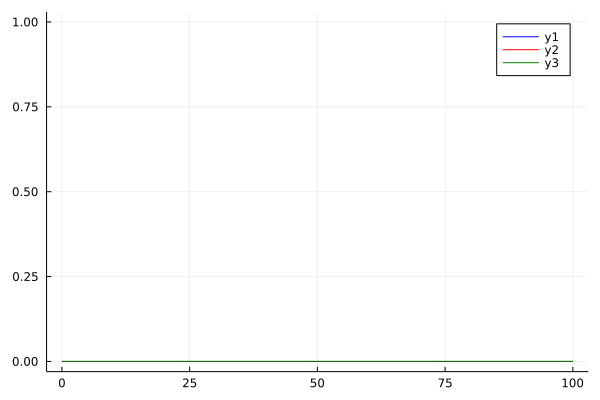

In [ ]:
N = sum(model.N_total) # Total initial population
x = data.step
Plots.plot(x, (data[:, aggname(:status, infected)]), color = :blue)
Plots.plot!(x, (data[:, aggname(:status, recovered)]), color = :red)
Plots.plot!(x, (N .- data[:, aggname(:status, length)]), color = :green)